# Walsh Floquet Counterdiabatic Driving
Since the start of my PhD, I have been saying this should be tested, so I might as well go and test it. I want to see if I can find a variational solution to the counterdiabatic drive for the following system:
$$\hat{H}(t) = B_z \sigma^z + B_x \text{Sq}(t) \sigma^x,$$
where we drive the system with a square wave that is a single mode in the Walsh basis. We can imagine that we allow $B_x$ to also be time-dependent (henceforth referred to as $\lambda(t)$) and we want to remain in a given Floquet state via counterdiabatic driving. 

The counterdiabatic form of the Hamiltonian is given by
$$\hat{H}_{CD, \lambda(t)} = \hat{H}_{\lambda(t)}(t) + \dot{\lambda} \mathcal{A}_{\lambda(t)}(t).$$

The FAGP can be approximated using the variational principle
$$\mathcal{A}_\lambda \approx \chi_\lambda \text{ where } \mathcal{S}[\chi_\lambda] = \int_0^T \text{Tr}[\mathcal{G}^2(\chi_\lambda(t))] \text{d}t,$$
and we define $\mathcal{G}(\chi_\lambda) = i[H_\lambda(t), \chi_\lambda(t)]+ \partial_t \chi_\lambda-\partial_\lambda H_\lambda$.

While generically it is very complicated to solve for this, we are restricted to the Hilbert space of a single spin and can reduce $\chi_\lambda$ to have four components corresponding to the Pauli matrices. This gives
$$\chi_\lambda = \mathbf{a}(t) \cdot \sigma.$$

## Calculation Functions
For later use, it is in our interest to define several useful pieces. For example, the Pauli matrices among others. We will just define the Walsh derivative locally here for now. For this first pass, we define the functions as three index tensors $f_{ijt}$ where $ij$ describe the physical Hilbert space and t describes the time evolution parameter.

In [204]:
import numpy as np
import scipy.linalg as sp
import matplotlib.pyplot as plt
import timeit

#Pauli matrices
s0 = np.eye(2)
s1 = np.array([[0,1],[1,0]])
s2 = np.array([[0,-1j],[1j,0]])
s3 = np.array([[1,0],[0,-1]])
paulis=[s1,s2,s3]

#Using the definition as the generator of translations, finds the derivative in the Walsh basis.
#input is N=2**n.
def WalshD(N):
    Walsh=sp.hadamard(N) #Generate all the Walsh functions from the Hadamard array.
    translatedWalsh=np.roll(Walsh,1,axis=1) #Shift the whole thing over by 1 by simply pushing all the columns periodically 1.
    Translation=1/N*np.matmul(translatedWalsh,np.transpose(Walsh)) #Invert Ax=x' to A=x' x^T to find the translation operator.

    return N/(2*np.pi)*sp.logm(Translation) #Rewrite it as generator of translations where T=exp(2 pi G/N).

def Deriv(N):
    sites=np.eye(N)
    translatedsites=np.roll(sites,1,axis=1)
    Translation=1/N*np.matmul(translatedsites,np.transpose(sites)) #Invert Ax=x' to A=x' x^T to find the translation operator.

    return N/(2*np.pi)*sp.logm(Translation) #Rewrite it as generator of translations where T=exp(2 pi G/N).

#generate operator set for a given number of modes, N
def genOs(N):
    Os=[]
    Walsh=1/np.sqrt(N)*sp.hadamard(N) #Normalise the Hadamard
    for i in range(N):
        Wi=Walsh[:,i]
        for s in paulis:
            O=np.stack([s*w for w in Wi], axis=2)
            Os.append(O)
    return Os

def genDOs(N):
    DOs=[]

    #Find the derivatives of the Walsh functions in real time
    DWalsh=1/np.sqrt(N)*WalshD(N)@sp.hadamard(N) #Normalise the Hadamard
    for i in range(N):
        DWi=DWalsh[i,:] #Rows are the time-dependence of the differentiated Walsh functions
        for s in paulis:
            DO=np.stack([s*w for w in DWi], axis=2)
            DOs.append(DO)
    return DOs

#Takes a 2 x 2 hermitian matrix and decomposes it into its constituent paulis
def PauliDecompose(H):
    return 1/2*np.trace(H@s1), 1/2*np.trace(H@s2), 1/2*np.trace(H@s3)

#Time dep pauli decompose
def Paulit(Ht):
    Nt=np.shape(Ht)[-1]
    fs=np.empty((3,Nt), dtype='complex')
    for i in range(Nt):
        f1,f2,f3=PauliDecompose(Ht[:,:,i])
        fvec=[f1,f2,f3]
        for p in range(3): #Iterate over kind of pauli. Identity doesn't affect AGP definition, so don't include.
            fs[p,i]=fvec[p]
    return fs

#OR could do it this way but need to use the derivative in real time.
#Walsh derivative acting in the correct way.


## Checking functions
Here we set up some functions to help us make sure that our results make sense.

In [239]:
def commutator(A,B):
    #Finds the commutator for A_{ij, t} and B_{ij, t} for all t.
    #Returns a tensor $C_{ij, t}$ which is the commutator of the matrices at each time
    return np.einsum('ijt,jkt->ikt', A, B)-np.einsum('ijt,jkt->ikt', B, A) 

def D(Op,N): #take some operator [a,b,t] and find the Walsh derivative with respect to the t part.
    Walshd=WalshD(N)
    drealspace=-1/N*sp.hadamard(N)@Walshd@sp.hadamard(N) #
    return np.einsum('ab,jkb->jka', drealspace, Op)  #np.tensordot(Op, drealspace, axes=([2], [1]))

def testS6(Agp, Ht, dlHt, N):
    Gt=1.j*commutator(Ht,Agp)+D(Agp,N)-dlHt
    return 1.j*commutator(Ht,Gt)+D(Gt,N)

In [237]:
#Testing the derivative
N=16
Ops=genOs(N)
DOps=genDOs(N)

n=15
sxW1=Ops[3*n]
Ops[6][:,:,3] #This is sx*W1(t), single root square wave. 
DsxW1=DOps[3*n]
#print(sxW1[:,:,5])
# print(sxW1[0,1,:])
# print(DsxW1[0,1,:])
DsxW12=D(sxW1,N)
print(sxW1[0,1,:])
print(np.sum(np.abs(DsxW12[0,1,:]+DsxW1[0,1,:])))

[ 0.25 -0.25 -0.25  0.25 -0.25  0.25  0.25 -0.25 -0.25  0.25  0.25 -0.25
  0.25 -0.25 -0.25  0.25]
4.9942208217310606e-14


In [197]:
WalshD(4)@[0,0,0,1]

array([ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
       -1.00000000e+00+1.67279143e-32j,  4.18552161e-16+1.48959365e-16j])

In [205]:
WalshD(4)@sp.hadamard(4)

array([[ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j],
       [-2.38541601e-16+2.00000000e+00j,  2.38541601e-16-2.00000000e+00j,
        -2.38541601e-16+2.00000000e+00j,  2.38541601e-16-2.00000000e+00j],
       [-1.00000000e+00-1.61534465e-16j,  1.00000000e+00-1.61534465e-16j,
         1.00000000e+00+1.61534465e-16j, -1.00000000e+00+1.61534465e-16j],
       [ 1.00000000e+00+1.48959365e-16j,  1.00000000e+00-1.48959365e-16j,
        -1.00000000e+00-1.48959365e-16j, -1.00000000e+00+1.48959365e-16j]])

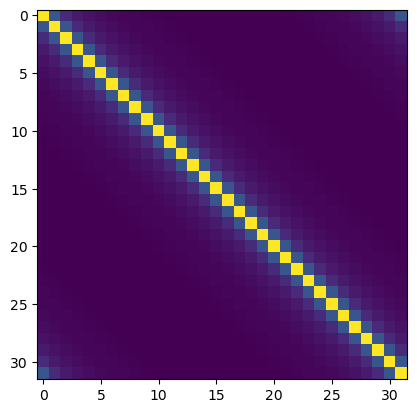

In [5]:
plt.imshow(np.abs(Deriv(32)))

# Case 1
As the simplest first case we study
$$H(t)= \lambda \sigma^z + (g+ A\cdot \text{Sq}(t)) \sigma^x.$$

We store this information by using three indices. The Hamiltonian is H(t) is written as H[i,j,t] where the third direction gives time. To take the trace over the physical Hilbert space part, it is just ```numpy.trace(H, axis1=0, axis2=1).``` All the operators are also written this way.

What we ultimately want to calculate is
$$
\begin{align}
M_{jk}(\lambda)&= \int \text{d}\phi\, \mathrm{Tr} \left[ g_{j,\lambda}(\phi)g_{k,\lambda}(\phi) \right] \\
b_{j}(\lambda)&= \int \text{d}\phi \mathrm{Tr} \left[ g_{j,\lambda}(\phi) \partial_{\lambda} H_{\lambda}(\phi) \right] \\
g_{j,\lambda}(\phi)&= i[H_{\lambda}(\phi), O_{j}(\phi)] +\partial_{\phi}(O_{j}(\phi))
\end{align}
$$

We store the $O_j$ as "Ops" where the first three elements are time independent $\sigma_x, \sigma_y, \sigma_z$ then the next three are $\sigma_x W_1(t), \sigma_y W_1(t), \sigma_z W_1(t)$ where the label is the natural ordering for the Walsh and so varies with $N$.

We can then find $\mathbf{x}=\mathbf{M}^{-1} \mathbf{b}$ which defines our approximate AGP as
$$\chi=\sum x_n \hat{O}_n$$

In [15]:
def AGP_vary_z(lam, Ops, DOps, sz, sx, Sqtsx, N):
    """
    Variational AGP construction for a given lambda.

    Parameters
    ----------
    lam : float
        Current value of lambda.
    Ops : np.ndarray
        Operator basis, shape (NOs, 2, 2, N).
        Index order: (basis_index, a, b, t).
    DOps : np.ndarray
        Derivative w.r.t. phi of each operator, same shape as Ops.
    sz, sx, Sqtsx : np.ndarray
        Time-dependent operators (2,2,N) needed to build H(t).
    N : int
        Number of discrete time points.

    Returns
    -------
    AGPapprox : np.ndarray
        Approximate AGP tensor, shape (2, 2, N).
    """
    NOs = Ops.shape[0]

    # Hamiltonian and its lambda derivative
    Ht   = lam * sz + 1.0 * sx + 3.0 * Sqtsx  # g=1, A=3
    dlHt = sz

    # Allocate
    gmatrices = np.empty((NOs, 2, 2, N), dtype=complex)
    bvector   = np.empty((NOs,), dtype=complex)
    Mmatrix   = np.empty((NOs, NOs), dtype=complex)

    # Build g matrices and b vector
    for j in range(NOs):
        gmatrix = 1j * commutator(Ht, Ops[j]) + DOps[j]
        gmatrices[j] = gmatrix
        # b_j = Tr[g_j dlH], integrated over time
        bmatrix = np.sum(np.trace(np.einsum('ijt,jkt->ikt', gmatrix, dlHt),
                                  axis1=0, axis2=1))
        bvector[j] = bmatrix

    # Build M matrix
    for j1 in range(NOs):
        for j2 in range(j1+1):
            val = np.sum(np.trace(np.einsum('ijt,jkt->ikt',
                                            gmatrices[j1], gmatrices[j2]),
                                  axis1=0, axis2=1))
            Mmatrix[j1, j2] = val
            Mmatrix[j2, j1] = val  # Hermitian

    # Solve M X = b
    Xvector = np.linalg.solve(Mmatrix, bvector)

    # Construct approximate AGP
    AGPapprox = np.einsum('j,jabt->abt', Xvector, Ops)

    return AGPapprox

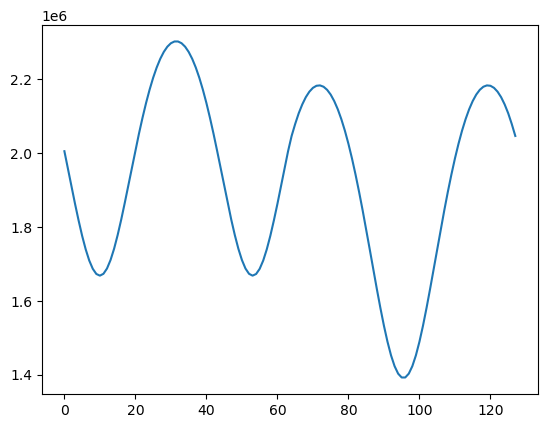

In [13]:
n=7
N=2**n
#Generate operator set
Ops=genOs(N)
DOps=genDOs(N)

sz=Ops[2]
sx=Ops[0]
Sqtsx=Ops[int(N/2)*3] #sx is multiples of 3, square wave is the N/2th mode.
dSqtsx=DOps[int(N/2)*3]

l=1 #1
g=1 #1
A=0.1 #3
#In the Os basis
Ht=l*sz+g*sx+A*Sqtsx
dlHt=sz

NOs=len(Ops)
gmatrices=np.empty((NOs,2,2,N),dtype='complex') #j, a,b, t are the indices.
bvector=np.empty((NOs),dtype='complex') #j, a,b, t are the indices.
Mmatrix=np.empty((NOs,NOs), dtype='complex')

#Now want to find g matrix g[a,b][t] along with the bvector b[j]
for index in range(NOs):
    gmatrix=1.j*commutator(Ht,Ops[index])+DOps[index]
    bmatrix=np.sum(np.trace(np.einsum('ijt,jkt->ikt', gmatrix, dlHt) ,axis1=0,axis2=1)) #TK can optimise this later in terms of run time.

    #Store the values
    gmatrices[index,:,:,:]=gmatrix
    bvector[index]=bmatrix

#Calculate the M matrices as well. (TK Unchecked)
for index1 in range(NOs):
    for index2 in range(index1+1): #go up to index1 to populate diagonals too.
        Mmatrix[index1,index2]=np.sum(np.trace(np.einsum('ijt,jkt->ikt', gmatrices[index1], gmatrices[index2]), axis1=0,axis2=1)) #Outer sum is just the integral.
        Mmatrix[index2,index1]=Mmatrix[index1,index2]

#plt.plot(np.abs(bvector)) #bvector only has 2 components which is sensible. Only works for


#Now we can find the X vector that allows us to construct the approximate AGP
Xvector=np.linalg.inv(Mmatrix)@bvector
AGPapprox=np.einsum('j,jabt->abt', Xvector, Ops)
plt.plot(np.abs(AGPapprox[1,0,:]))

# Case 2
As the next case, we study
$$H(t)= B_z \sigma^z + (g+ \lambda \cdot \text{Sq}(t)) \sigma^x,$$

which is nice since it has the interpretation of a ramp in the driving strength. Otherwise, the procedure for calculation is the same as the first case.

In [240]:
def AGP_vary_A(lam, Ops, DOps, sz, sx, Sqtsx, N):
    """
    Variational AGP construction for a given lambda.

    Parameters
    ----------
    lam : float
        Current value of lambda.
    Ops : np.ndarray
        Operator basis, shape (NOs, 2, 2, N).
        Index order: (basis_index, a, b, t).
    DOps : np.ndarray
        Derivative w.r.t. phi of each operator, same shape as Ops.
    sz, sx, Sqtsx : np.ndarray
        Time-dependent operators (2,2,N) needed to build H(t).
    N : int
        Number of discrete time points.

    Returns
    -------
    AGPapprox : np.ndarray
        Approximate AGP tensor, shape (2, 2, N).
    """
    NOs = len(Ops) #Since it is a list of operators

    # Hamiltonian and its lambda derivative
    Ht   = 1 * sz + 0.5 * sx + lam * Sqtsx  # Bz=1, g=0.5
    dlHt = Sqtsx

    # Allocate
    gmatrices = np.empty((NOs, 2, 2, N), dtype=complex)
    bvector   = np.empty((NOs,), dtype=complex)
    Mmatrix   = np.empty((NOs, NOs), dtype=complex)

    # Build g matrices and b vector
    for j in range(NOs):
        gmatrix = 1j * commutator(Ht, Ops[j]) + DOps[j]
        gmatrices[j] = gmatrix
        # b_j = Tr[g_j dlH], integrated over time
        bmatrix = np.sum(np.trace(np.einsum('ijt,jkt->ikt', gmatrix, dlHt),
                                  axis1=0, axis2=1))
        bvector[j] = bmatrix

    # Build M matrix
    for j1 in range(NOs):
        for j2 in range(j1+1):
            val = np.sum(np.trace(np.einsum('ijt,jkt->ikt',
                                            gmatrices[j1], gmatrices[j2]),
                                  axis1=0, axis2=1))
            Mmatrix[j1, j2] = val
            Mmatrix[j2, j1] = val  # Hermitian

    # Solve M X = b
    Xvector = np.linalg.solve(Mmatrix, bvector)

    # Construct approximate AGP
    AGPapprox = np.einsum('j,jabt->abt', Xvector, Ops)
    constraint = testS6(AGPapprox, Ht, dlHt, int(NOs/3)) #Find the number of modes from number of operators.
    return AGPapprox, constraint

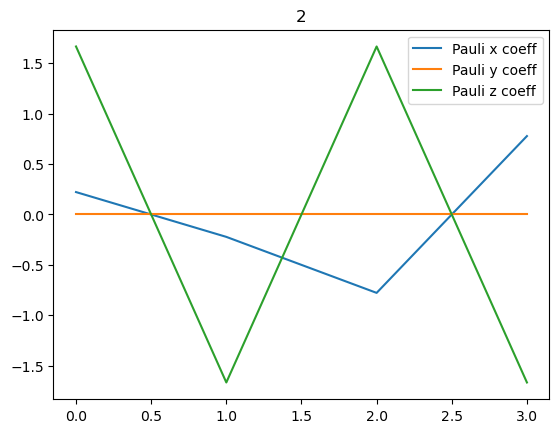

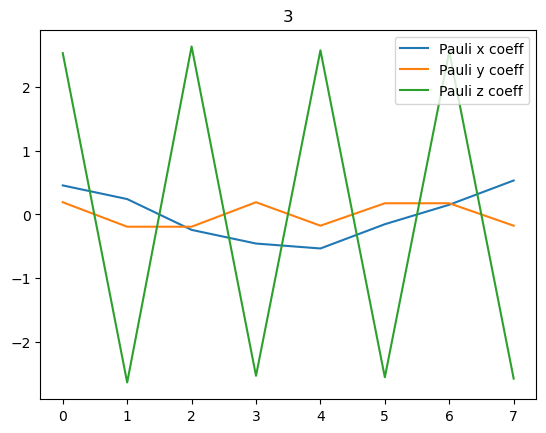

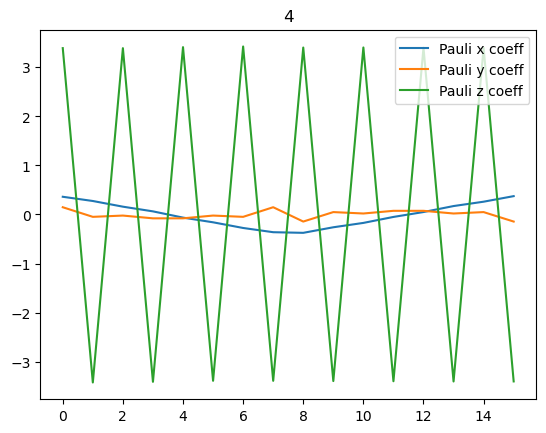

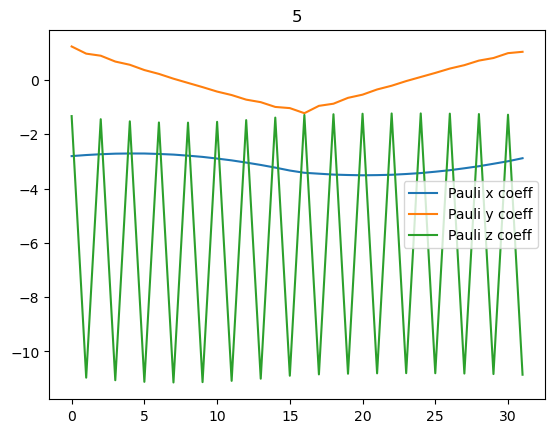

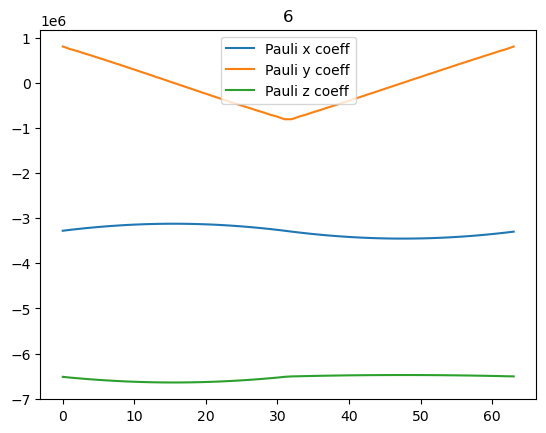

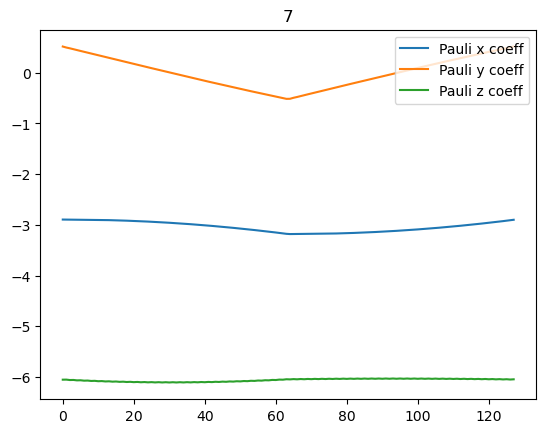

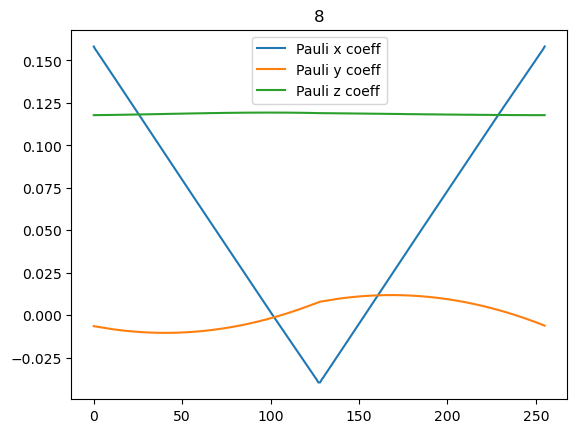

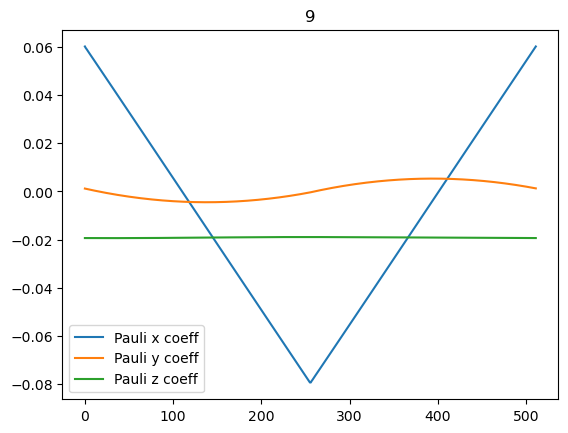

In [276]:
#lambdas=np.arange(0,10,1)

constraints=[]

nvals=np.arange(2,10,1) #11

for n in nvals:
    N=2**n
    #Generate operator set
    Ops=genOs(N)
    DOps=genDOs(N)
    
    sz=Ops[2]
    sx=Ops[0]
    Sqtsx=Ops[int(N/2)*3] #sx is multiples of 3, square wave is the N/2th mode.
    
    #Calculate for a specific lambda and plot
    AGP_approx,constraint=AGP_vary_A(0.3, Ops, DOps, sz, sx, Sqtsx, N) #0.1
    #plt.plot(np.abs(AGP_approx[1,1,:]))
    
    #plt.show()
    constraints.append(constraint)
    #Decompose into different paulis
    funcs=Paulit(AGP_approx)
    plt.plot(funcs[0,:], label="Pauli x coeff")
    plt.plot(funcs[1,:], label="Pauli y coeff")
    plt.plot(funcs[2,:], label="Pauli z coeff")
    plt.title(n)
    plt.legend()
    plt.show()

# for lam in lambdas:
#     AGP_vary_A(lam, Ops, DOps, sz, sx, Sqtsx, N)

In [277]:
fitness=[np.average(np.abs(constraint)) for constraint in constraints]
fitness

[11.666666666674942,
 49.02950358298129,
 231.6084676257945,
 1251.712961878277,
 120688.2101799415,
 10.32588502213849,
 0.09992706477429317,
 0.00043567887984051815]

In [272]:
cos

0.0024672624372201572

In [76]:
lambdas=np.arange(0,10,1)
n=4
N=2**n
#Generate operator set
Ops=genOs(N)
DOps=genDOs(N)

sz=Ops[2]
sx=Ops[0]
Sqtsx=Ops[int(N/2)*3] #sx is multiples of 3, square wave is the N/2th mode.

#Calculate for a specific lambda and plot
AGP_approx2=AGP_vary_A(1, Ops, DOps, sz, sx, Sqtsx, N)

In [194]:
DOps[3][:,:,6]

array([[-0.00000000e+00+0.j, -4.77083202e-16+4.j],
       [-4.77083202e-16+4.j, -0.00000000e+00+0.j]])

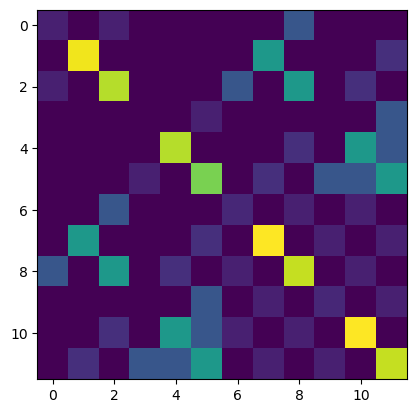

In [7]:
plt.imshow(np.abs(Mmatrix))

In [174]:
np.sum(np.einsum('ijt,jkt->ikt', Ht, Ops[12]),axis=2)

array([[24,  0],
       [ 0, 24]])

# Case 2
Can we write everything in the Walsh basis to speed up the code? Gets hard just because we have phi phi terms which are a convolution in the Walsh basis, which is not obvious at all.
As the simplest first case we study
$$H(t)= \lambda \sigma^z + (g+ A\cdot \text{Sq}(t)) \sigma^x.$$

We store this information by using three indices. The Hamiltonian is H(t) is written as H[i,j,t] where the third direction gives time. To take the trace over the physical Hilbert space part, it is just ```numpy.trace(H, axis1=0, axis2=1).``` All the operators are also written this way.

What we ultimately want to calculate is
$$
\begin{align}
M_{jk}(\lambda)&= \int \text{d}\phi\, \mathrm{Tr} \left[ g_{j,\lambda}(\phi)g_{k,\lambda}(\phi) \right] \\
b_{j}(\lambda)&= \int \text{d}\phi \mathrm{Tr} \left[ g_{j,\lambda}(\phi) \partial_{\lambda} H_{\lambda}(\phi) \right] \\
g_{j,\lambda}(\phi)&= i[H_{\lambda}(\phi), O_{j}(\phi)] +\partial_{\phi}(O_{j}(\phi))
\end{align}
$$

We store the $O_j$ as "Ops" where the first three elements are time independent $\sigma_x, \sigma_y, \sigma_z$ then the next three are $\sigma_x W_1(t), \sigma_y W_1(t), \sigma_z W_1(t)$ where the label is the natural ordering for the Walsh and so varies with $N$. Working natively in the Walsh basis, we find that we can write 
$\sum_\phi A_\phi B_\phi = \sum_l \tilde{A}_l \tilde{B}_l$ where the Walsh modes come from $A_\phi = \sum W_l(\phi) \tilde{A}_l$. This means that when expressed natively in the Walsh basis, we have
$$
\begin{align}
M_{jk}(\lambda)&= \sum_l \, \mathrm{Tr} \left[ \tilde{g}_{j,\lambda,l} \tilde{g}_{k,\lambda,l} \right] \\
b_{j}(\lambda)&= \sum_l \mathrm{Tr} \left[ \tilde{g}_{j,\lambda,l} \partial_{\lambda} \tilde{H}_{\lambda,l} \right] \\
g_{j,\lambda}(\phi)&= i[H_{\lambda}(\phi), O_{j}(\phi)] +\partial_{\phi}(O_{j}(\phi))
\end{align}
$$

# Extensive Checks

## Check on the Ops functions
Here we check that all the Ops functions are working as expected.

In [235]:
DOps=genDOs(4) #Generate the time derivative of the operators in the correct way using the discretised derivative. 
DOps[6][0,1,:] #Derivative of Walsh2 which is -Walsh3
DOps[9][0,1,:] #Derivative of Walsh3 which is Walsh2

array([ 1.+1.48959365e-16j,  1.-1.48959365e-16j, -1.-1.48959365e-16j,
       -1.+1.48959365e-16j])

In [212]:
def original(g, d):
    # If your real dlHt is (J, K, T), transpose once here to (J, I, T) before benchmarking
    # d = d.transpose(0,2,1)  # uncomment if needed
    return np.sum(np.trace(np.einsum('ijt,jkt->ikt', g, d), axis1=0, axis2=1))

def einsum_fast(g, d):
    return np.einsum('ijt,jit->', g, d, optimize=True)

def swapmul_fast(g, d):
    return (g * d.swapaxes(0, 1)).sum()

# correctness check
r1 = original(gmatrix, dlHt)
r2 = einsum_fast(gmatrix, dlHt)
r3 = swapmul_fast(gmatrix, dlHt)
print("equal? original vs einsum:", np.allclose(r1, r2))
print("equal? original vs swap  :", np.allclose(r1, r3))

# timing
n = 10000
t1 = timeit.timeit(lambda: original(gmatrix, dlHt), number=n)
t2 = timeit.timeit(lambda: einsum_fast(gmatrix, dlHt), number=n)
t3 = timeit.timeit(lambda: swapmul_fast(gmatrix, dlHt), number=n)

print(f"\nTimings over {n} runs:")
print(f"original      : {t1:.4f} s")
print(f"einsum_fast   : {t2:.4f} s")
print(f"swapmul_fast  : {t3:.4f} s")

equal? original vs einsum: True
equal? original vs swap  : True

Timings over 10000 runs:
original      : 0.0604 s
einsum_fast   : 0.0883 s
swapmul_fast  : 0.0164 s


## Sorting out the derivative

In [209]:
# def WalshD(N):
#     Walsh=sp.hadamard(N) #Generate all the Walsh functions from the Hadamard array.
#     translatedWalsh=np.roll(Walsh,1,axis=1) #Shift the whole thing over by 1 by simply pushing all the columns periodically 1.
#     Translation=1/N*np.matmul(translatedWalsh,np.transpose(Walsh)) #Invert Ax=x' to A=x' x^T to find the translation operator.
Walsh=sp.hadamard(4)
translatedWalsh=np.roll(Walsh,-1,axis=1)
Translation=1/N*np.matmul(translatedWalsh,np.transpose(Walsh))

[[ 1  1  1  1]
 [ 1 -1  1 -1]
 [ 1  1 -1 -1]
 [ 1 -1 -1  1]]
[[ 1  1  1  1]
 [-1  1 -1  1]
 [ 1 -1 -1  1]
 [-1 -1  1  1]]


In [210]:
def WalshD2(N):
    Walsh=sp.hadamard(N) #Generate all the Walsh functions from the Hadamard array.
    translatedWalsh=np.roll(Walsh,-1,axis=1) #Shift the whole thing over by 1 by simply pushing all the columns periodically 1.
    Translation=1/N*np.matmul(translatedWalsh,np.transpose(Walsh)) #Invert Ax=x' to A=x' x^T to find the translation operator.

    return N/(2*np.pi)*sp.logm(Translation) #Rewrite it as generator of translations where T=exp(2 pi G/N).

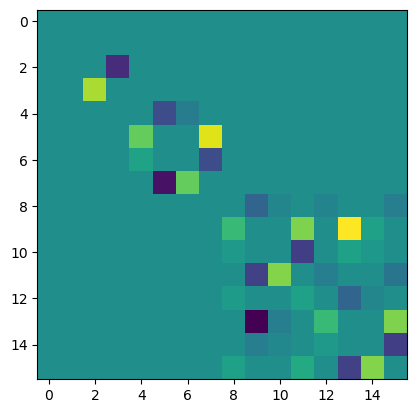

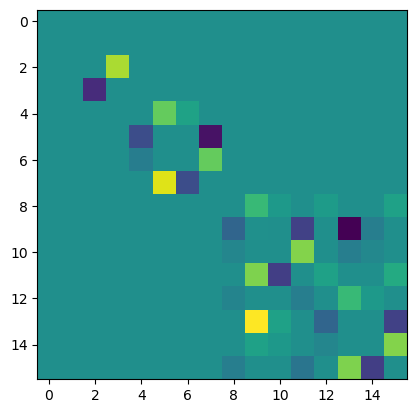

In [218]:
#Only differ by a minus sign.
plt.imshow(np.real(WalshD(16)))
plt.show()
plt.imshow(np.real(WalshD2(16)))